# MEIxplica - Data Challenge Santander*

Projeto desenvolvido para o hackathon promovido pela Shawee com o intuito de utilizar a ciência de dados para apoiar micro e médio empreendedores diante da crise sanitária e agora econômica decorrente do novo coronavírus. O objetivo desse notebook é explorar, tratar e analisar os dados a fim de gerar insights para o pequeno e médio empreendedor do varejo principalmente por meio do ensino da interpretação desses dados no site:

[MEIxplica](https://sites.google.com/view/meixplica)

A plataforma visa atuar de forma aberta permitindo que os usuários que possuam conhecimento possam acessar esse notebook e avançar em seus estudos do mercado.

_*Projeto desenvolvido entre os dias 01 e 02 de agosto de 2020._



# Configuração do Ambiente
Nesta seção realizam-se os imports e instalação das bibliotecas necessárias no ambiente remoto. 

Selenium foi utilizado para fazer scrapping de dados dinâmicos na 

1.   Selenium     - Raspagem de dados da internet;
2.   Numpy        - Funções matemáticas e manipulação de matrizes para computação científica;
3.   Pandas       - Manipulação e tratamento de dados;
4.   Matplotlib   - Representação gráfica vetorial de resultados;
5.   Seaborn      - Representação gráfica vetorial de resultados;
6.   BeatifulSoup - Raspagem de dados da internet e tratamento de arquivos html;
7.   Pytrends     - Consulta direta da base de dados de tendências do Google.


### Instalação de bibliotecas faltantes



In [ ]:
!pip3 install selenium 
!pip3 install pytrends
# Instalacao de drivers para seu navegador, como fazer isso no Colab??? 
# https://pypi.org/project/selenium/

!apt-get update 
!apt install chromium-chromedriver

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,853 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:

### Importação de ferramentas necessárias de suas bibliotecas

In [ ]:
from pytrends.request import TrendReq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from selenium import webdriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Estudo IPCA
Consultando o portalbrasil que atualiza o Índice Nacional de Preços ao Consumidor Amplo (IPCA), foi proposto um estudo inicial do seu comportamento nos últimos 15 anos para uma primeira conscientização do seu comportamento.

### Webdriver para consulta ao site

In [ ]:
driver = webdriver.Chrome('chromedriver',options=chrome_options)
url_ipca = "https://www.portalbrasil.net/ipca/"
driver.get( url_ipca )

table = driver.find_element_by_xpath('//table[@class="has-fixed-layout"]')

html_table = table.get_attribute( 'outerHTML' )
soup_table = BeautifulSoup( html_table, 'html.parser' )

df_ipca = pd.read_html( str(soup_table) )[0]

df_ipca.columns = ['Date', 'Monthly', 'Percent', 'CumSum', 'Trash']
df_ipca['CumSum'] = df_ipca['CumSum'].astype(float)/10000
df_ipca = df_ipca.iloc[::-1]
df_ipca[['Date','CumSum']].to_csv(r'ipca_cumsum.csv', index = False)

driver.quit()


### Evolução do IPCA acumulado de 12 meses 

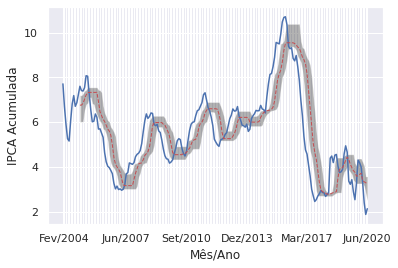

In [ ]:
months = 12   # Set the roll period for median study
roll = df_ipca['CumSum'].rolling(months)
first_quartile_ipca = roll.quantile(0.25)
third_quartile_ipca = roll.quantile(0.75)
median_ipca = roll.median()

for i in range(months):
  roll.median()[len(median_ipca)-i-2] = df_ipca['CumSum'].median()
  roll.median()[len(median_ipca)-i-2] = df_ipca['CumSum'].median()
  roll.median()[len(median_ipca)-i-2] = df_ipca['CumSum'].median()

fig, ax = plt.subplots()

x = np.arange(-100, 300, 0.1 )
ax.fill_between( range(198), first_quartile_ipca, third_quartile_ipca, facecolor='black', alpha=0.3 )
ax.plot( df_ipca.Date, df_ipca.CumSum, '-' )
ax.plot( range(198), median_ipca, color='r', linestyle='dashed', linewidth=1)
ax.set_xlabel('Mês/Ano')
ax.set_ylabel('IPCA Acumulada')

labels = ax.get_xticklabels();
labels = ['' for i in range(len(labels))];
for i in range(5):
  labels[i*int(len( median_ipca)/5 ) ] = df_ipca.Date[ i*int((len(median_ipca)-2)/5)];
labels[len(median_ipca)-2] = df_ipca.Date[ len(median_ipca)-2];
ax.set_xticklabels( reversed(labels) );

## Estudo de Indice de Comércio

In [ ]:
!pwd

indice_comercio = pd.read_excel("pmc_202005_05.xls",
                   header=4,
                   nrows=15,
                   usecols="A:N",
                   index_col = 0)

drop = ['Comércio Varejista (1)',
        '4. Móveis e eletrodomésticos',
        'Comércio Varejista Ampliado (2)']

indice_comercio.drop(drop, inplace = True)

months_mapper = {'jan': 1,
             'fev': 2,
             'mar': 3,
             'abr': 4,
             'mai': 5,
             'jun': 6,
             'jul': 7,
             'ago': 8,
             'set': 9,
             'out': 10,
             'nov': 11,
             'dez': 12}

def subs_month_number(mes):
    
    if type(mes) == str:
        mes,ano = mes.split("/")
        mes = months_mapper[mes]
        date = f'{mes}/{ano}'
        return pd.to_datetime(date)
    
    return mes

indice_comercio.columns = indice_comercio.columns.map(lambda mes: subs_month_number(mes))

indice_comercio = indice_comercio.T

/content


No handles with labels found to put in legend.


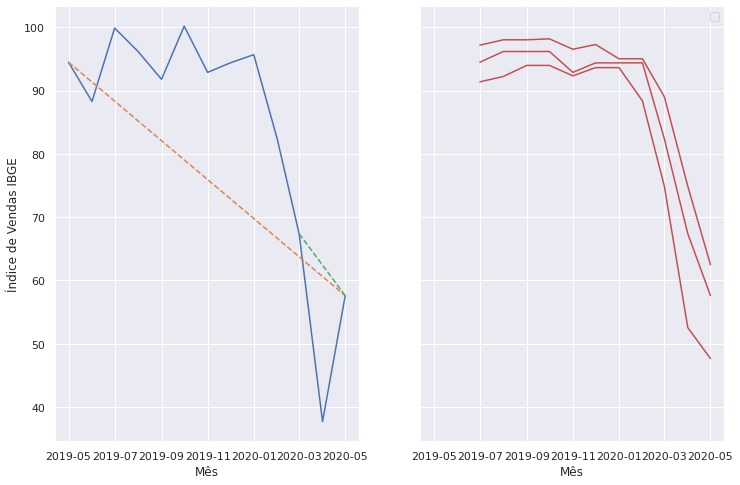

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize = (12,8))

col = indice_comercio.columns[-2]    
ax1.plot(col, data = indice_comercio, label = col)


##Comparação com Maio de 2019
x = indice_comercio.index[0]
y = indice_comercio.loc[x,col]
x_ = indice_comercio.index[-1]
y_ = indice_comercio.loc[x_,col]
X = [x,x_]
Y = [y,y_]
ax1.plot(X,Y, linestyle = '--')

##Comparação com Março de 2020
x = indice_comercio.index[-3]
y = indice_comercio.loc[x,col]
x_ = indice_comercio.index[-1]
y_ = indice_comercio.loc[x_,col]
X = [x,x_]
Y = [y,y_]
ax1.plot(X,Y, linestyle = '--')

plt.legend(loc = 1)
ax1.set_xlabel("Mês")
ax1.set_ylabel("Índice de Vendas IBGE")
ax2.set_xlabel("Mês")

colors = sns.color_palette()
roll = indice_comercio.rolling(3)
ax2.plot(col, data = roll.median(), color = colors[3])
ax2.plot(col, data = roll.quantile(0.25), color = colors[3])
ax2.plot(col, data = roll.quantile(0.75), color = colors[3])

## Tendências de consumo em grandes sites de compra

In [ ]:
# Scrapping de Tendência ML
url_trends = "https://tendencias.mercadolivre.com.br/"
driver_ml = webdriver.Chrome('chromedriver',options=chrome_options)
driver_ml.get(url_trends)

links = driver_ml.find_elements_by_xpath("//div[@class='andes-card sidebar__card']//ul//li//a")

category = []
for x in links:
    print("\n " + str(x.text) )
    url_prod = str(x.get_attribute('href'))

    userAgents=[
        "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/74.0.3729.157 Safari/537.36",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.1 Safari/605.1.15"
    ]


    products=[]

    doc = requests.get(url_prod)
        
    analizador = BeautifulSoup(doc.content, 'html.parser')
        
    produtos = analizador.find_all('li', class_="searches__item")
        
    for unidade in produtos:
        uni={}
        uni['produto']  = unidade.find("a").contents[0].strip() 
        
        products.append(uni)
        
    all_prods = pd.DataFrame(columns=uni.keys())
    all_prods = all_prods.append(products)

    category.append(all_prods)


 Acessórios para Veículos
                     produto
0               caixa de som
1                   chuveiro
2             som automotivo
3               motos usadas
4                      opala
5           radio automotivo
6    caixa de som automotivo
7                 caixa trio
8            caixinha de som
9                       moto
10              caixinha som
11                     kombi
12              fusca antigo
13        jaqueta motoqueiro
14                     motos
15   som automotivo completo
16                       gol
17        central multimidia
18                    hornet
19     carregador de bateria
20                  pneus 13
21                  pneus 14
22            modulo taramps
23         macaco hidraulico
24                  mobilete
25           retrovisor f800
26                 dodge ram
27             mercedes c180
28         luva motociclista
29  som automotivo bluetooth
30                   gol gti
31              subwoofer 12
32              

## Tendências de buscas dos usuários no google trends

Esta seção avança em direção à construção de um sistema de recomendação compartilhado entre empreendedores do varejo, obtendo dados de bases consolidados e podendo contribuição dos usuários empreendedores com seus dados.

Outras possíveis fontes de dados podem ser acrescidas com o avanço desse estudo como o [Amazon Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html) e o [RED - Epinions](https://projet.liris.cnrs.fr/red/).

In [ ]:
# SCRAP CNAE BY UF
driver = webdriver.Chrome('chromedriver',options=chrome_options)
url_cnae = "http://www.portaldoempreendedor.gov.br/estatisticas"
driver.get( url_cnae )

time.sleep(5)
# driver.find_element_by_xpath("//div[@class='tab-pane active']//ul//li//a[contains(., = 'CNAE/UF')]").click()
driver.find_element_by_xpath("//*[contains(text(), 'CNAE/UF')]").click()

time.sleep(5)
ufs = driver.find_elements_by_xpath("//div[@id='form:identificacao_body']//select//option")

for uf in ufs:
    b.find_element_by_xpath("//select[@name='element_name']/option[@value={uf.text}]").click()
    time.sleep(3)
    driver.find_element_by_xpath('//div[@id="form:botaoExportarCsv"]').click()
    os.rename(r'relatorio_mei.csv',r('['+str(uf.text)+']relatorio_mei.csv'))

In [ ]:
trend = TrendReq(hl='pt-BR', tz=180)
item = all_produtos.iloc[0,0]
trend.build_payload([item], cat=0, timeframe='today 3-m', geo='BR', gprop='froogle')

In [ ]:
trend.interest_over_time().head()

,tenis masculino,isPartial
date,,
2020-05-02,53,False
2020-05-03,35,False
2020-05-04,56,False
2020-05-05,75,False
2020-05-06,55,False


In [ ]:
trend.interest_by_region(resolution='REGION').head()

,tenis masculino
geoName,
Acre,0
Alagoas,31
Amapá,100
Amazonas,19
Bahia,36


In [ ]:
Queries = trend.related_queries()
Tendencia = Queries[item]['rising']
Top = Queries[item]['top']

In [ ]:
Tendencia

,query,value
0,tenis olympikus masculino,160
1,tenis mizuno masculino,100
2,tenis nike preto masculino,70
3,tenis new balance masculino,50
4,tenis reebok masculino,40


In [ ]:
Top.head()

,query,value
0,tenis masculino nike,100
1,tenis nike,97
2,tenis adidas masculino,68
3,tenis adidas,65
4,tenis branco masculino,30


## Estudo dos setores de MEIs mais afetados pela crise sanitária

In [ ]:
df = pd.read_csv("MEI_CNAE.csv")

In [ ]:
def achar_palavras(x, lista_de_palavras):
    for palavra in lista_de_palavras:
        if palavra.upper() in x.upper():
            return True
    return False

def plotMEI(df, titulo):
    
    df = df.sort_values("TOTAL", ascending=False)
    
    fig, ax = plt.subplots(figsize = (10,8))
    sns.barplot(x="TOTAL", y="Descrição", data=df, ax = ax)
    plt.title(titulo)
    plt.xlabel("Empreendedores MEI")

    total=df["TOTAL"].sum()
    for p in ax.patches:
        percentage ='{:,.3f}%'.format(100*p.get_width()/total)
        width, height =p.get_width(),p.get_height()
        x=p.get_x()+width+0.02
        y=p.get_y()+height/2
        ax.annotate(percentage,(x,y))
        
    indexes, texts = plt.yticks()
    for text in texts:
        split_text = text.get_text().split(" ")
        break_index = int(len(split_text)/2) + 1
        split_text.insert(break_index,"\n")
        new_text = ' '.join(split_text)
        text.set_text(new_text)

    plt.yticks(indexes, texts)

In [ ]:
#Setor de Combustíveis e lubrificantes
lista = ['lubrifi','combus']
bol1 = df["Descrição"].apply(lambda x: achar_palavras(x,lista))
bol2 = df[bol1]["Descrição"].apply(lambda x: 'Comércio' in x)
df_lub = df[bol1][bol2]

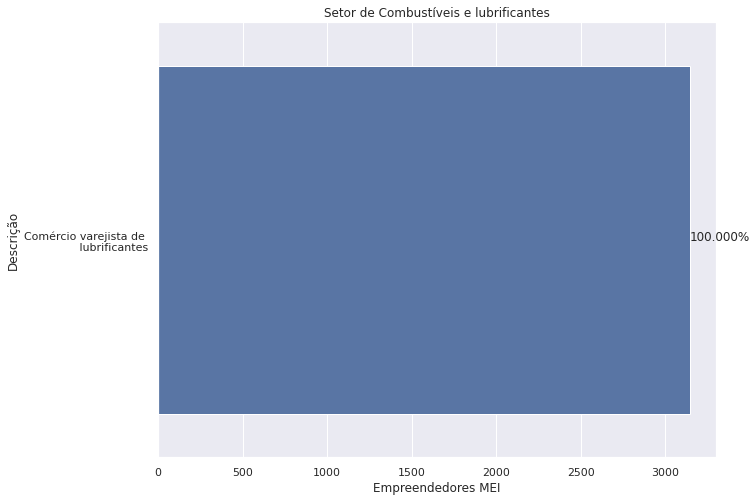

In [ ]:
titulo = 'Setor de Combustíveis e lubrificantes'
plotMEI(df_lub,titulo)

In [ ]:
#Setor de Tecidos, vestuário e calçados
lista = ['tecid','vestu','calç','sapa']
bol1 = df["Descrição"].apply(lambda x: achar_palavras(x,lista))
bol2 = df[bol1]["Descrição"].apply(lambda x: 'Comércio var' in x)
df_vest = df[bol1][bol2]

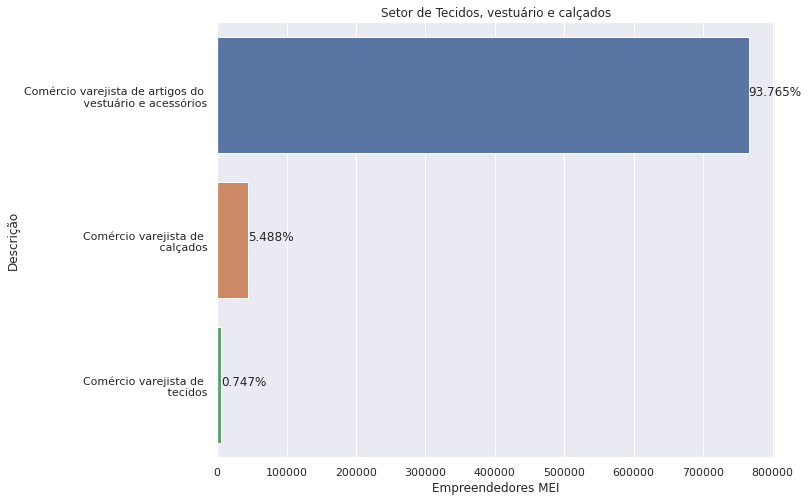

In [ ]:
titulo = 'Setor de Tecidos, vestuário e calçados'
plotMEI(df_vest,titulo)

In [ ]:
# Setor Artigos farmacêuticos, médicos, ortopédicos, de perfumaria e cosméticos
lista = ['farma','médic','ortop','perfum','cosmé']
bol1 = df["Descrição"].apply(lambda x: achar_palavras(x,lista))
bol2 = df[bol1]["Descrição"].apply(lambda x: 'Comércio var' in x)
df_farm = df[bol1][bol2]

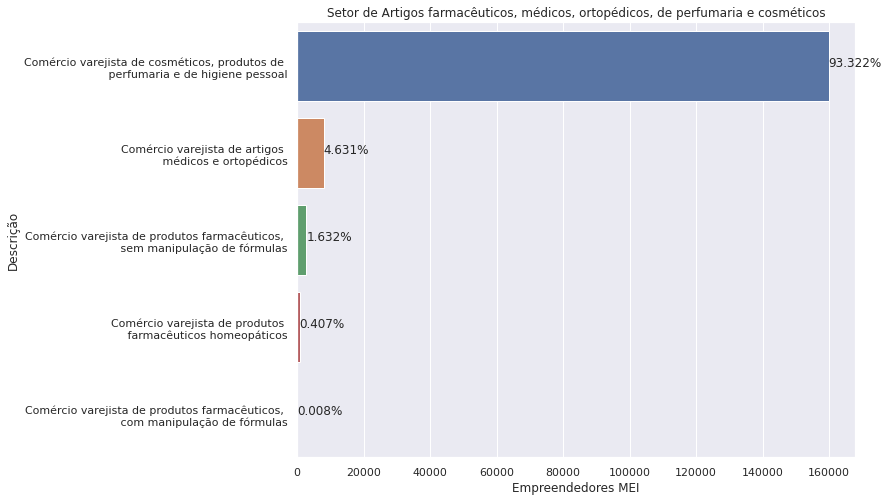

In [ ]:
titulo = 'Setor de Artigos farmacêuticos, médicos, ortopédicos, de perfumaria e cosméticos'
plotMEI(df_farm,titulo)

In [ ]:
# Setor Livros, jornais, revistas e papelaria'
lista = ['livr','jorna','revis','papela']
bol1 = df["Descrição"].apply(lambda x: achar_palavras(x,lista))
bol2 = df[bol1]["Descrição"].apply(lambda x: 'Comércio' in x)
df_livr = df[bol1][bol2]

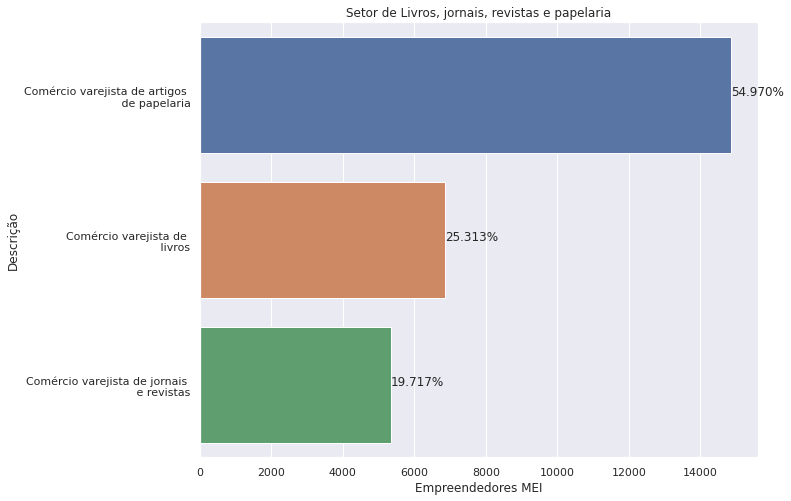

In [ ]:
titulo = 'Setor de Livros, jornais, revistas e papelaria'
plotMEI(df_livr,titulo)

In [ ]:
# Setor Equipamentos e materiais para escritório, informática e comunicação
lista = ['escrit','inform','comunica']
bol1 = df["Descrição"].apply(lambda x: achar_palavras(x,lista))
bol2 = df[bol1]["Descrição"].apply(lambda x: 'Comércio var' in x)
df_escrt = df[bol1][bol2]

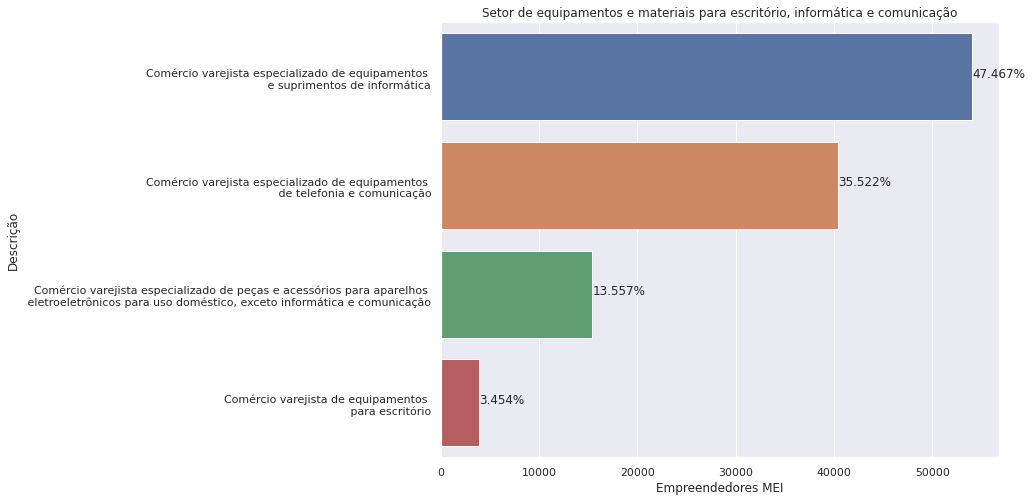

In [ ]:
titulo = 'Setor de equipamentos e materiais para escritório, informática e comunicação'
plotMEI(df_escrt,titulo)

In [ ]:
# Setor Veículos, motocicletas, partes e peças
lista = ['veíc','moto']
bol1 = df["Descrição"].apply(lambda x: achar_palavras(x,lista))
bol2 = df[bol1]["Descrição"].apply(lambda x: 'Comércio a var' in x)
df_veic = df[bol1][bol2]

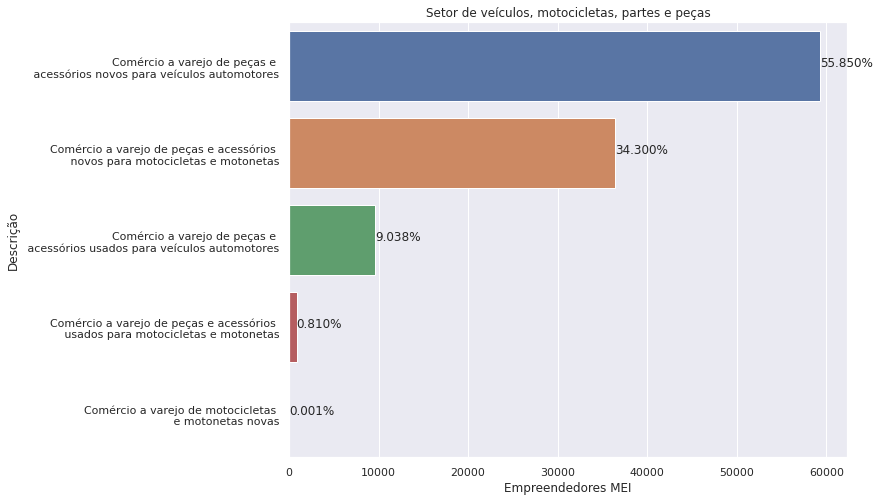

In [ ]:
titulo = 'Setor de veículos, motocicletas, partes e peças'
plotMEI(df_veic,titulo)